<style>
.jp-RenderedHTMLCommon h1:before { counter-increment: h1counter; content: counter(h1counter, decimal) ". "; counter-reset: h2counter; }
.jp-RenderedHTMLCommon { counter-reset: h1counter 1; }
</style>

<style>
/* Ocultar numeración automática de Jupyter */
.jp-RenderedHTMLCommon h1:before,
.jp-RenderedHTMLCommon h2:before,
.jp-RenderedHTMLCommon h3:before { 
    content: none !important; 
}
</style>

# Filtrar y procesar la señal de EEG

Materias relacionadas: Instrumentación Biomédica, Electrofisiología, Temas Selectos en Biomatemáticas y Temas Selectos en Biofísica.

Antecedentes: Notebook 1

## Filtrado de la señal

En el notebook anterior trabajamos con una visualización cruda. Donde se ven artefactos y fluctuaciones. Una forma de mitigar estos efectos es usar filtros pasabandas.

El procesamiento digital de señales aplicado al EEG requiere una comprensión sólida de los principios fundamentales que rigen la adquisición, digitalización y filtrado de señales biomédicas (Hari & Puce, 2017). Las señales de EEG presentan características únicas que requieren consideraciones especiales en su procesamiento.

### 2.1.1 Digitalización y teorema de muestreo

Según el teorema de muestreo de Nyquist-Shannon, para representar fielmente una señal continua en el dominio digital, la frecuencia de muestreo debe ser al menos el doble de la frecuencia más alta presente en la señal (Saptono et al., 2016). Para EEG, donde las frecuencias de interés van típicamente de 0.5 a 100 Hz, una frecuencia de muestreo de 128 Hz como la utilizada en el sistema Emotiv EPOC+ es apropiada para analizar hasta 64 Hz (EMOTIV, 2016).

### 2.1.2 Características del ruido en señales de EEG

Las señales de EEG están contaminadas por diversos tipos de ruido y artefactos que pueden clasificarse según su origen (Ramos-Argüelles et al., 2009):

1. **Ruido de línea eléctrica (50/60 Hz)**: Proveniente de la red eléctrica
2. **Artefactos oculares**: Movimientos y parpadeos
3. **Artefactos musculares**: Actividad EMG superpuesta
4. **Ruido de electrodo**: Impedancia y movimiento
5. **Drift de línea base**: Fluctuaciones lentas del potencial

## 2.2 Tipos de Filtros y su Aplicación en EEG

Los filtros digitales se clasifican según las frecuencias que permiten pasar (Baranowski et al., 2017):

| Filtro | Función | Aplicación |
|--------|---------|------------|
| Pasabajas | Atenúa las frecuencias por encima de una frecuencia de corte determinada | * Eliminar el ruido de alta frecuencia, por ejemplo el proveniente de la actividad muscular. * Aislar los componentes de baja frecuencia |
| Pasaaltas | Atenúa las frecuencias por debajo de una frecuencia de corte determinada | * Eliminar el ruido causado por los cambios de potencial de la piel. * Aislar componentes de alta frecuencia |
| Pasabandas | Permite pasar un rango de frecuencias, dando una frecuencia de corte alta y una frecuencia de corte baja | Obtener bandas de frecuencia específica dada su frecuencia de corte baja y su frecuencia de corte alta |

Obtenida con información de Baranowski et al., 2017.

## 2.3 Orden de los filtros

El orden de un filtro se refiere al número de polos o ceros que tiene la función de transferencia del filtro. Una función de transferencia es la representación matemática de cómo un sistema transforma una señal de entrada en una de salida (Rader, 2017). Mayor orden en el filtro implica mayor complejidad y mayor capacidad para aproximar una respuesta en frecuencia ideal (Widmann et al., 2015).

### 2.3.1 Filtros de Butterworth: características y ventajas

Los filtros de Butterworth se caracterizan por tener una respuesta en frecuencia maximamente plana en la banda de paso, sin ondulaciones (Rader, 2017). Las ventajas principales incluyen (Widmann et al., 2015):

1. **Respuesta plana en banda de paso**: Sin ondulaciones
2. **Comportamiento predecible**: Fácil de diseñar y implementar
3. **Estabilidad**: Filtros siempre estables
4. **Transición gradual**: Evita artefactos de filtrado abrupto

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import signal
from scipy.fft import fft, fftshift
import os.path as os
from scipy.fftpack import fft, ifft
from scipy.signal import filtfilt, butter

In [18]:
carpeta = os.abspath('/Users/yann/Documents/Tesis/Datos/EEG/') #localización del
#archivo en tu computadora
datos = pd.read_csv(carpeta +'/H24_OC_OA.csv') #creación de un dataframe
#al que únicamente debes modificar el nombre del archivo con su extensión
datos #comando para presentar el dataframe

,EEG.AF3,EEG.F7,EEG.F3,EEG.FC5,EEG.T7,EEG.P7,EEG.O1,EEG.O2,EEG.P8,EEG.T8,EEG.FC6,EEG.F4,EEG.F8,EEG.AF4
0,4339.49,4521.03,4187.69,4627.69,4339.49,4112.31,4348.72,4252.31,4932.82,4447.69,4475.38,4738.46,4420.51,4598.46
1,4346.67,4527.18,4202.05,4633.85,4342.05,4122.05,4366.67,4267.69,4949.74,4465.64,4485.64,4749.74,4432.82,4611.28
2,4350.26,4540.00,4207.18,4643.08,4341.54,4122.05,4374.87,4271.28,4954.36,4462.56,4485.13,4747.18,4430.77,4612.31
3,4337.95,4530.77,4198.46,4638.46,4336.92,4118.97,4372.31,4258.97,4936.92,4441.03,4472.31,4734.87,4413.85,4598.46
4,4334.87,4519.49,4189.23,4629.23,4342.05,4118.97,4369.74,4245.64,4923.08,4436.41,4471.28,4731.79,4416.41,4596.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23122,4414.87,4522.05,4201.54,4683.08,4384.62,4105.64,4361.54,4217.44,4892.82,4362.05,4493.85,4757.44,4426.67,4627.18
23123,4413.85,4524.10,4200.51,4685.64,4388.72,4106.15,4349.74,4196.92,4875.90,4346.67,4476.92,4749.74,4412.82,4614.36
23124,4416.41,4523.08,4204.62,4690.26,4391.28,4102.05,4337.44,4183.59,4875.90,4349.74,4477.95,4752.82,4412.31,4616.41
23125,4413.85,4520.51,4205.13,4687.69,4383.08,4094.36,4336.41,4183.59,4875.90,4352.31,4485.64,4753.33,4413.33,4617.95


In [19]:
fm=128 #frecuencia de muestreo
ti=0 #tiempo de inicio, debe ser número entero
tf=180 #tiempo final, debe ser número entero
pt=(tf-ti)*fm#numero de puntos
t1=ti*fm #nos ayuda a dar la posición de la fila para el tiempo inicial
t2=tf*fm #nos ayuda a dar la posición de la fila para el tiempo final
nombres=list(datos) #almacena los nombres de los encabezados en una lista
t=np.linspace(ti,tf,pt)
filtg=[]
for i in range (0,14):
    al=np.array(datos)[t1:t2,i]
    nyq = 128*0.5 #frecuencia de muestreo y ripple
    low = 2 / nyq #ancho de banda inferior
    high = 45 / nyq #ancho de banda superior
    b, a = butter(3, [low, high], btype='band') #filtro de orden 3
    env = filtfilt(b, a, al)
    filtg.append(env)

In [20]:
tmp=pd.DataFrame(filtg, nombres)
datosfilt=tmp.transpose()
datosfilt

,EEG.AF3,EEG.F7,EEG.F3,EEG.FC5,EEG.T7,EEG.P7,EEG.O1,EEG.O2,EEG.P8,EEG.T8,EEG.FC6,EEG.F4,EEG.F8,EEG.AF4
0,-0.128496,-0.004399,-1.469067,0.270211,0.058634,-0.508915,-0.217883,-1.391201,-1.115832,-0.443911,-0.428767,-0.474621,-1.323994,-0.246727
1,7.671067,7.011786,12.871696,6.287464,3.310929,9.740998,17.376371,15.454531,17.197943,19.321944,10.905300,11.897454,11.931317,13.137052
2,8.033013,16.089285,16.956630,13.258683,1.122358,10.210517,25.038911,19.081265,20.845004,15.754805,8.490137,8.969693,6.744544,11.959070
3,-2.168620,8.793873,8.480013,8.918432,-1.874214,8.181461,22.318835,8.906341,5.190716,-3.212725,-2.299727,-1.518214,-7.828871,-0.572966
4,-6.903274,-3.254394,-0.884019,-1.186795,2.679588,7.886220,18.877838,-4.008122,-7.782132,-6.974407,-3.407644,-4.354934,-5.869413,-2.897676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23035,11.146999,20.319526,4.890808,11.313464,14.357408,8.653156,5.212346,9.629029,10.883352,10.217472,6.693151,-1.681891,11.982120,10.696170
23036,9.757597,16.580722,-1.352441,7.721112,6.386291,0.633796,-5.002812,-4.360598,-0.631860,-5.382822,-8.930875,-7.620935,0.350823,1.781615
23037,10.028386,7.667015,7.047453,9.501885,-1.320009,-6.186195,-16.372522,-12.033577,-2.834473,-2.733871,-9.008043,-1.365510,-3.191554,2.816388
23038,7.667414,3.481073,13.842084,9.369325,-2.713827,-7.032514,-18.276471,-11.212975,-0.372908,6.084994,0.640885,4.562803,-0.124273,5.307917


## 2.4 Aplicación de un filtro pasabandas de orden 3

En este caso el filtrado va de 2 a 45 Hz pues es el rango que nos interesa filtrar. Tomando en cuenta que estamos trabajando con una frecuencia de muestreo de 128 Hz tenemos parámetros para construir el filtro. El teorema de muestreo de Nyquist-Shannon establece que para representar fielmente una señal continua en el dominio digital, la frecuencia de muestreo debe ser al menos el doble de la frecuencia más alta presente en la señal (Saptono et al., 2016). La frecuencia de Nyquist se calcula con la siguiente fórmula:

$$f_n = \frac{f_s}{2}$$

Aplicando este cálculo para la frecuencia de interés que estamos trabajando, el cálculo se haría de la siguiente forma:

$$f_n = \frac{f_s}{2} = \frac{128Hz}{2} = 64 Hz$$

De lo anterior sabemos que la máxima frecuencia representable para construir el filtro es de 64 Hz (Widmann et al., 2015). Ahora llevamos este cálculo a los parámetros fisiológicos que nos interesan para la construcción del filtro. Al tratarse de un filtro pasabandas debemos fijar el ancho de banda inferior y el ancho de banda superior.

### 2.4.1 Selección de frecuencias de corte

**Respecto a la frecuencia baja (2 Hz)**: Queremos usarla para eliminar el ruido que pueda venir de la actividad cardiaca y el drift de línea base. Los artefactos de baja frecuencia, incluyendo fluctuaciones cardiacas y movimientos lentos, típicamente se encuentran por debajo de 1-2 Hz (Ramos-Argüelles et al., 2009). Si la frecuencia inferior fuera de 1 Hz únicamente estaría representada la actividad que se encuentra en un valor máximo de 64 latidos por minuto pero si se pone una frecuencia de 2 Hz podríamos eliminar el ruido de actividad cardiaca en el intervalo de 0 y 128 latidos por minuto. La selección de 2 Hz como frecuencia de corte baja es estándar en el procesamiento de EEG para preservar las ondas delta (1-4 Hz) mientras se eliminan artefactos de muy baja frecuencia (Widmann et al., 2015).

**Haciendo un recordatorio de las bandas de frecuencia que nos interesan para analizar EEG tenemos lo siguiente:**

| Tipo de onda | Rango de frecuencia | Localización | En estado fisiológico |
|--------------|-------------------|--------------|---------------------|
| Delta | 1-4 Hz | En adolescentes y niños pequeños en la parte posterior de la cabeza. | Aparece durante el ritmo normal de sueño, y en uno de cada tres adultos puede apreciarse cuando se está despierto con los ojos abiertos |
| Theta | 4-8 Hz | Puede estar ausente, pero si se encuentra, está en la línea media y derivaciones temporales. | Marcada en niños pequeños. Somnolencia en adultos |
| Alfa | 8-13 Hz | Regiones frontocentrales pero también distribución amplia | Con los ojos cerrados, mientras se está relajado |
| Beta | 13-30 Hz | Regiones posteriores de la cabeza | Con los ojos abiertos, mientras se está relajado. La actividad es mayor en un lado dominante |
| Gamma | >30 Hz | Distribución amplia pero principalmente centrales y temporales | Cognición |

*Información basada en Olejniczak (2006) y Hari & Puce (2017).*

### Frecuencia de corte superior

**En cuanto a la frecuencia alta (45 Hz)**: Se fija en 45 Hz considerando varios factores técnicos y fisiológicos. Primero, el análisis se está centrando en las ondas alfa (8-13 Hz), que son fundamentales para el protocolo experimental de ojos abiertos/cerrados (Hari & Puce, 2017). Segundo, las ondas gamma de alta frecuencia están reportadas en la literatura en el rango de 30-100 Hz, pero para este análisis no es relevante incluir frecuencias superiores a 45 Hz (Olejniczak, 2006). 

Para esta serie de notebooks, un análisis fundamental va a ser el cambio en la actividad de la banda Alfa. También nos interesan las contribuciones de cada banda, pero debido a que sólo se puede representar fielmente la señal hasta 64 Hz (frecuencia de Nyquist) y que las tareas cognitivas se diseñaron específicamente para representar las ondas Alfa, la selección de 45 Hz como frecuencia de corte superior es apropiada (Ramos-Argüelles et al., 2009). Adicionalmente, esto permite eliminar la mayoría de artefactos musculares que típicamente aparecen por encima de 30-40 Hz (Shoka et al., 2019).

## 2.5 Uso de filtros para remover artefactos

Un filtro pasabandas de Butterworth actúa como una ventana que deja pasar solo las señales que se encuentran dentro de un rango específico de frecuencias (Rader, 2017). Un filtro de Butterworth tiene las siguientes características establecidas en la literatura de procesamiento de señales biomédicas (Widmann et al., 2015):

- **Permitir el paso de señales** dentro de un rango específico de frecuencias, conocido como banda de paso.
- **Atenuar las señales** fuera de la banda de paso, en las bandas de rechazo inferior y superior.
- **Tener una respuesta en frecuencia plana** en la banda de paso, sin ondulaciones significativas.
- **Tener una transición gradual** entre la banda de paso y las bandas de rechazo.
- **Su función de transferencia** se caracteriza por una atenuación monótona en las bandas de rechazo.

**Ventajas de los filtros Butterworth para EEG** (Baranowski et al., 2017):
- Respuesta en frecuencia plana en la banda de paso
- Transición gradual entre la banda de paso y las bandas de rechazo  
- Fácil de implementar computacionalmente
- Comportamiento estable y predecible
- Ampliamente validados en aplicaciones de EEG clínico

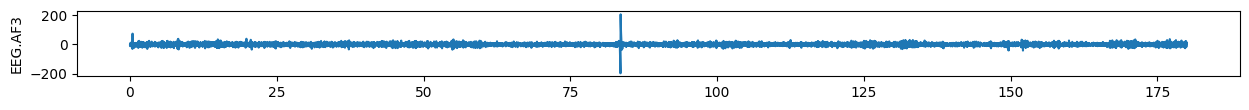

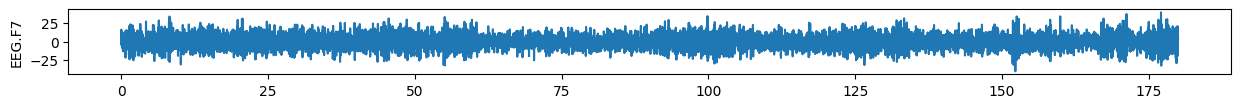

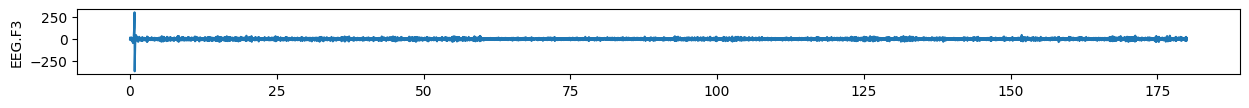

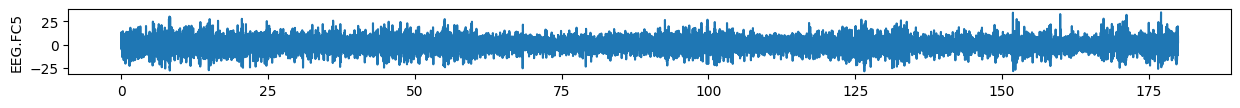

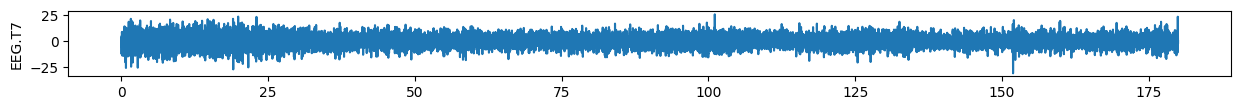

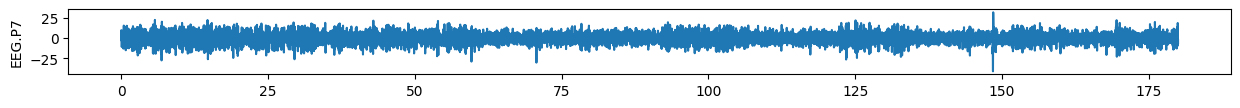

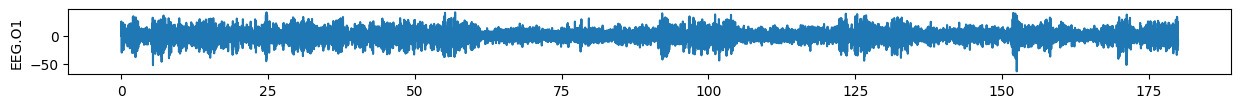

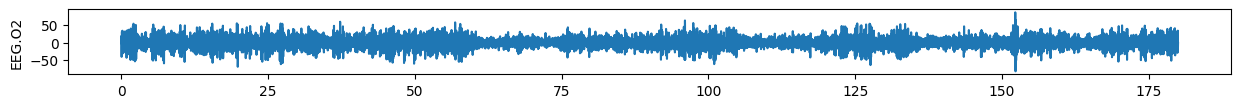

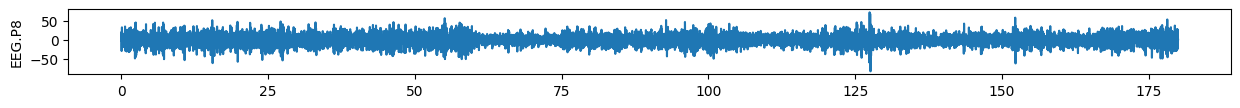

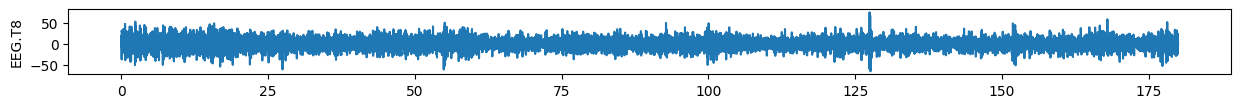

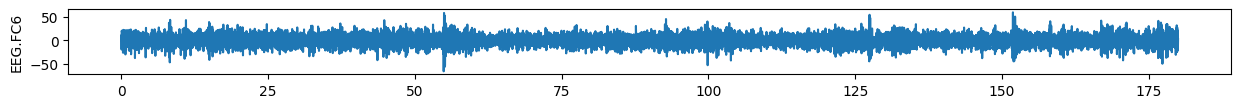

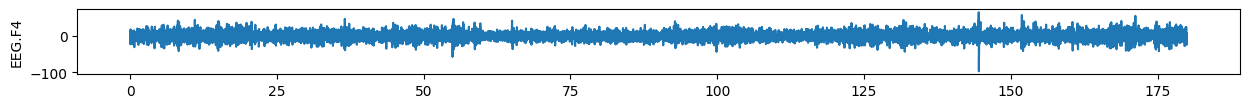

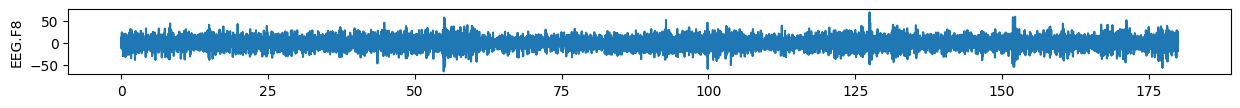

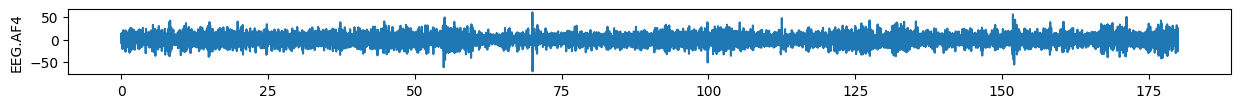

In [21]:
for i in range (0,14):
    plt.figure(figsize=(15,15))
    plt.subplot(15,1,i+1) #(filas, columnas, i)
    plt.plot(t,np.array(datosfilt)[t1:t2,i])
    plt.ylabel(nombres[i])#itera sobre el nombre de las columnas para dar título a los gráficos
    plt.show()

Las gráficas anteriores corresponden a la actividad eléctrica en cada electrodo después del proceso de filtrado pasabandas. Podemos observar el efecto del filtrado en el voltaje, donde se han eliminado las fluctuaciones de baja frecuencia (drift DC) y el ruido de alta frecuencia (Widmann et al., 2015). Sin embargo, por la resolución temporal de las gráficas se dificulta observar los cambios en la actividad cerebral relacionados con el protocolo experimental. 

Por esto será necesario reducir el tiempo inicial y el tiempo final para tener un efecto de zoom en la actividad de alguno de los canales, particularmente en los períodos de interés del protocolo: ojos abiertos (105-120s) y ojos cerrados (120-135s) donde esperamos observar cambios en la actividad alfa (Hari & Puce, 2017). El código para este propósito se muestra a continuación:

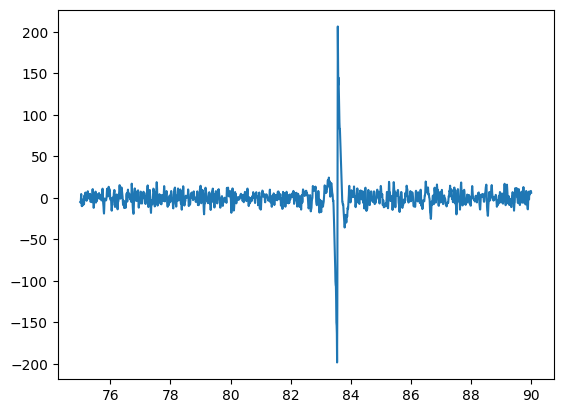

In [22]:
nc=0
fm=128 #frecuencia de muestreo
ti=75 #tiempo de inicio, debe ser número entero
tf=90 #tiempo final, debe ser número entero
pt=(tf-ti)*fm#numero de puntos
t1=ti*fm #nos ayuda a dar la posición de la fila para el tiempo inicial
t2=tf*fm #nos ayuda a dar la posición de la fila para el tiempo final
nombres=list(datos) #almacena los nombres de los encabezados en una lista
t=np.linspace(ti,tf,pt)
volt=np.array(datosfilt)[t1:t2,nc]
plt.plot(t, volt)

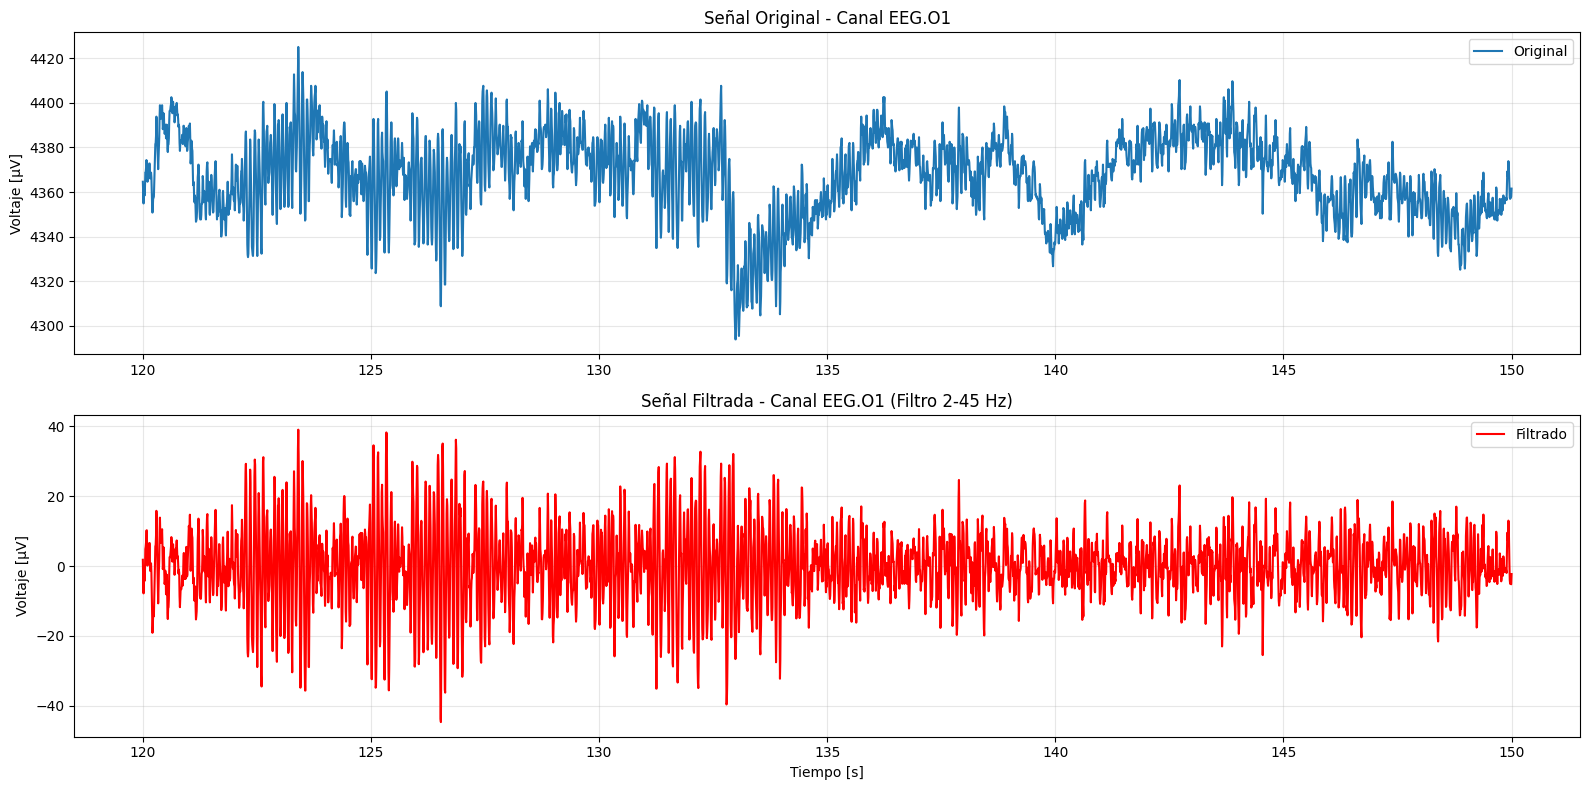

In [23]:
nc=6
ti_a=120
tf_a=150
pt=(tf_a-ti_a)*fm
t1_a=ti_a*fm
t2_a=tf_a*fm
t=np.linspace(ti_a,tf_a,pt)
volt=np.array(datos)[t1_a:t2_a,nc]
volt_filt=np.array(datosfilt)[t1_a:t2_a,nc]

# Gráfica
figure, axis = plt.subplots(2, 1, figsize=(16, 8))

# Voltaje original
axis[0].plot(t, volt, label="Original")
axis[0].set_ylabel("Voltaje [µV]")
axis[0].set_title(f'Señal Original - Canal {nombres[nc]}')
axis[0].legend()
axis[0].grid(True, alpha=0.3)

# Voltaje filtrado
axis[1].plot(t, volt_filt, label="Filtrado", color='red')
axis[1].set_ylabel("Voltaje [µV]")
axis[1].set_xlabel("Tiempo [s]")
axis[1].set_title(f'Señal Filtrada - Canal {nombres[nc]} (Filtro 2-45 Hz)')
axis[1].legend()
axis[1].grid(True, alpha=0.3)

# Ajustar la visualización
plt.tight_layout()

# Mostrar la gráfica
plt.show()

La visualización comparativa que se obtuvo facilitó observar los cambios de actividad en un periodo de tiempo más corto, permitiendo de esta forma visualizar las distintas bandas de frecuencia. En particular, podemos observar cómo el filtrado elimina el drift de línea base presente en la señal cruda mientras preserva las oscilaciones de interés, especialmente en la banda alfa (8-13 Hz), fundamental para nuestro análisis del protocolo de ojos abiertos/cerrados (Ramos-Argüelles et al., 2009).

El canal O1 (EEG.O1, canal 6) es particularmente relevante para este análisis ya que la actividad alfa se manifiesta prominentemente en las regiones occipitales cuando el sujeto mantiene los ojos cerrados en estado de relajación (Olejniczak, 2006).

## 2.6 Corrección de línea base con filtros pasa-altas

La corrección de línea base es un paso fundamental en el procesamiento de señales de EEG que permite eliminar el drift DC y las fluctuaciones de baja frecuencia que pueden contaminar la señal (Widmann et al., 2015). Estas fluctuaciones pueden deberse a varios factores técnicos y fisiológicos: movimientos del electrodo, cambios en la impedancia de contacto, sudoración del participante y artefactos de polarización del electrodo (Ramos-Argüelles et al., 2009).

### 2.6.1 Fundamentos teóricos de la corrección de línea base

El drift de línea base se manifiesta como cambios lentos en el voltaje promedio de la señal que no están relacionados con la actividad cerebral de interés (Baranowski et al., 2017). Para corregir este problema, se utiliza un filtro pasa-altas que atenúa las frecuencias por debajo de un valor de corte específico, típicamente entre 0.1 y 2 Hz para señales de EEG, dependiendo de la aplicación específica (Widmann et al., 2015).

La función de transferencia de un filtro pasa-altas de Butterworth está dada por:

$$H(f) = \frac{1}{\sqrt{1 + \left(\frac{f_c}{f}\right)^{2n}}}$$

Donde $f_c$ es la frecuencia de corte y $n$ es el orden del filtro (Rader, 2017).

In [24]:
# Corrección de línea base con filtro pasa-altas
def corregir_linea_base(datos, fm=128, fc_alta=0.5, orden=4):
    """
    Aplica corrección de línea base usando filtro pasa-altas
    
    Parámetros:
    datos: señal de entrada
    fm: frecuencia de muestreo (Hz)
    fc_alta: frecuencia de corte para pasa-altas (Hz)
    orden: orden del filtro
    """
    nyq = fm * 0.5
    high = fc_alta / nyq
    b, a = butter(orden, high, btype='high')
    datos_corregidos = filtfilt(b, a, datos)
    return datos_corregidos

# Aplicar corrección a los datos
fm = 128
canal = 6  # Canal O1 (occipital)
ti_ejemplo = 100
tf_ejemplo = 130
pt_ejemplo = (tf_ejemplo - ti_ejemplo) * fm
t1_ejemplo = ti_ejemplo * fm
t2_ejemplo = tf_ejemplo * fm
nombres = list(datos)
t_ejemplo = np.linspace(ti_ejemplo, tf_ejemplo, pt_ejemplo)

# Señal original
senal_original = np.array(datos)[t1_ejemplo:t2_ejemplo, canal]

# Señal con corrección de línea base
senal_corregida = corregir_linea_base(senal_original, fm, fc_alta=0.5, orden=4)

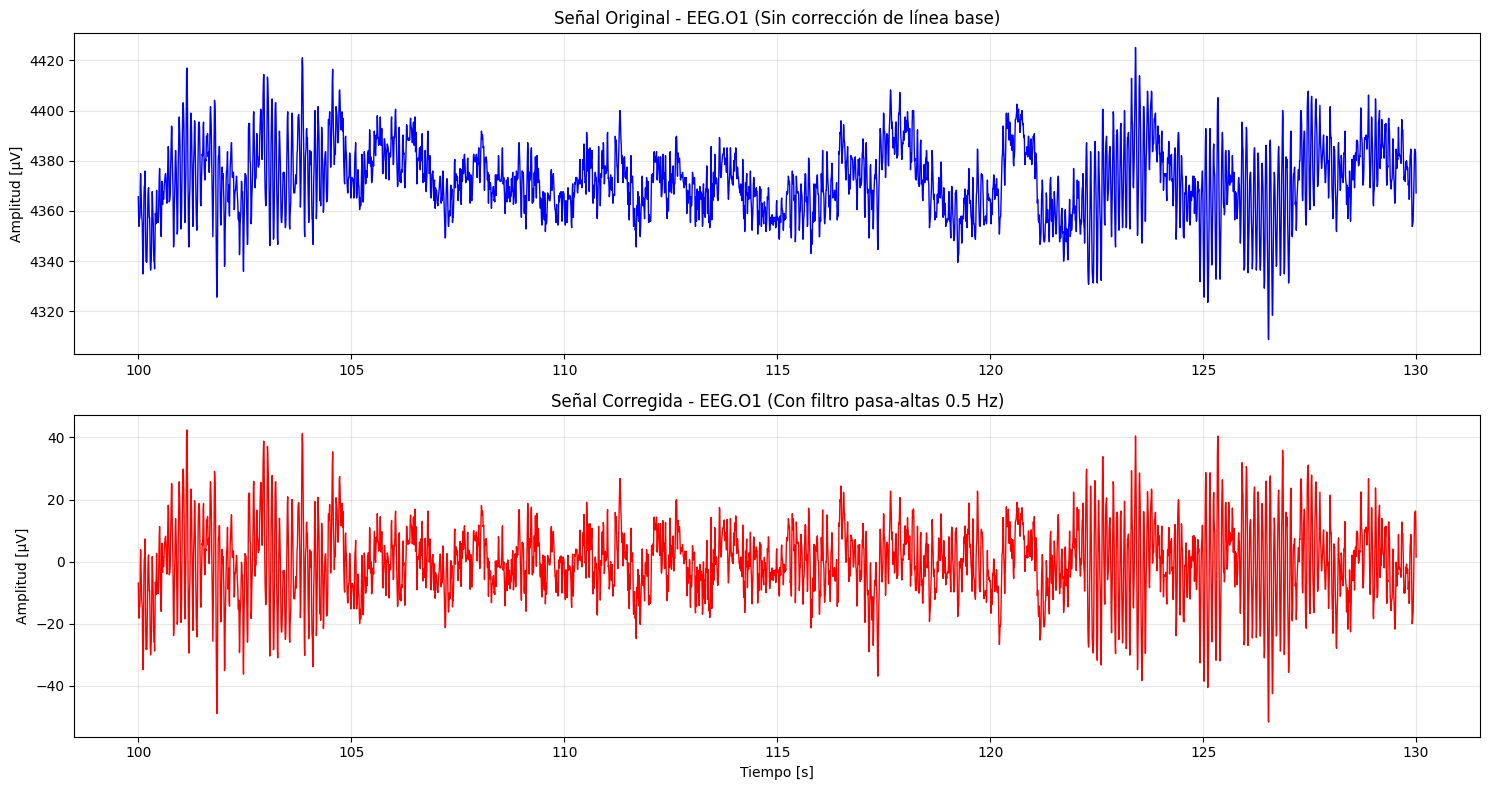

Voltaje promedio original: 4372.21 µV
Voltaje promedio corregido: -0.14 µV
Reducción del drift: 4372.35 µV


In [25]:
# Visualización comparativa
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(t_ejemplo, senal_original, 'b-', linewidth=1)
plt.title(f'Señal Original - {nombres[canal]} (Sin corrección de línea base)')
plt.ylabel('Amplitud [µV]')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(t_ejemplo, senal_corregida, 'r-', linewidth=1)
plt.title(f'Señal Corregida - {nombres[canal]} (Con filtro pasa-altas 0.5 Hz)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [µV]')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Voltaje promedio original: {np.mean(senal_original):.2f} µV")
print(f"Voltaje promedio corregido: {np.mean(senal_corregida):.2f} µV")
print(f"Reducción del drift: {np.mean(senal_original) - np.mean(senal_corregida):.2f} µV")

### 2.6.2 Filtrado bidireccional con filtfilt

La función `filtfilt` de SciPy implementa filtrado bidireccional que elimina el desfase temporal introducido por el filtro, una característica crucial para el análisis de señales biomédicas donde la sincronización temporal es importante (Widmann et al., 2015). El proceso consiste en:

1. **Filtrar la señal hacia adelante** aplicando el filtro en la dirección temporal normal
2. **Invertir la señal filtrada** temporalmente 
3. **Filtrar nuevamente hacia adelante** la señal invertida
4. **Invertir el resultado final** para restaurar la orientación temporal original

Este método duplica efectivamente el orden del filtro (de orden n a 2n) y elimina completamente la distorsión de fase, preservando las relaciones temporales entre diferentes componentes de frecuencia de la señal (Rader, 2017). Esta característica es particularmente importante para el análisis de EEG donde la fase relativa entre diferentes ritmos cerebrales puede tener significado fisiológico.

## 2.7 Ejercicios de Interpretación y Análisis

Los siguientes ejercicios están diseñados para reforzar la comprensión de los conceptos de filtrado digital aplicados a señales de EEG y desarrollar habilidades de interpretación crítica de los resultados (Shoka et al., 2019).

### Ejercicio 1: Análisis de artefactos en señales crudas

**Objetivo**: Desarrollar la capacidad de identificar diferentes tipos de artefactos en señales EEG no procesadas.

**Instrucciones**: Observa las visualizaciones de las señales sin filtrar del Notebook 1 y responde:

1. **Identificación de artefactos**:
   - ¿En qué electrodos observas los artefactos más prominentes y por qué?
   - ¿Qué tipo de artefactos identificas en AF3 alrededor de los 80 segundos?
   - ¿Cómo distingues entre actividad cerebral real y artefactos?

2. **Análisis temporal**:
   - ¿Observas diferencias visuales entre los períodos de ojos abiertos y cerrados?
   - ¿En qué regiones cerebrales (electrodos) esperarías ver mayor actividad alfa?

**Respuestas esperadas**: Los estudiantes deben identificar el artefacto de movimiento en AF3, reconocer que los electrodos occipitales (O1, O2) son cruciales para ondas alfa, y distinguir entre señal neuronal y ruido basándose en características de frecuencia y amplitud.

### Ejercicio 2: Parámetros de filtrado

**Objetivo**: Comprender el impacto de diferentes parámetros de filtro en la calidad y características de la señal procesada.

**Instrucciones**: Modifica los parámetros del filtro pasabandas y observa los efectos en la señal resultante.

**Preguntas de análisis**:
1. ¿Cómo afecta reducir la frecuencia de corte baja de 2 Hz a 0.5 Hz en la preservación de ondas delta?
2. ¿Qué sucede cuando aumentas el orden del filtro de 3 a 6 en términos de selectividad y posibles artefactos?
3. ¿Por qué un filtro muy estrecho (5-15 Hz) podría ser problemático para un análisis general de EEG?
4. ¿Cuál sería el impacto de usar una frecuencia de corte superior de 25 Hz en lugar de 45 Hz?

**Consideraciones teóricas**: La selección de parámetros de filtro representa un compromiso entre eliminación de ruido y preservación de información fisiológica relevante (Baranowski et al., 2017).

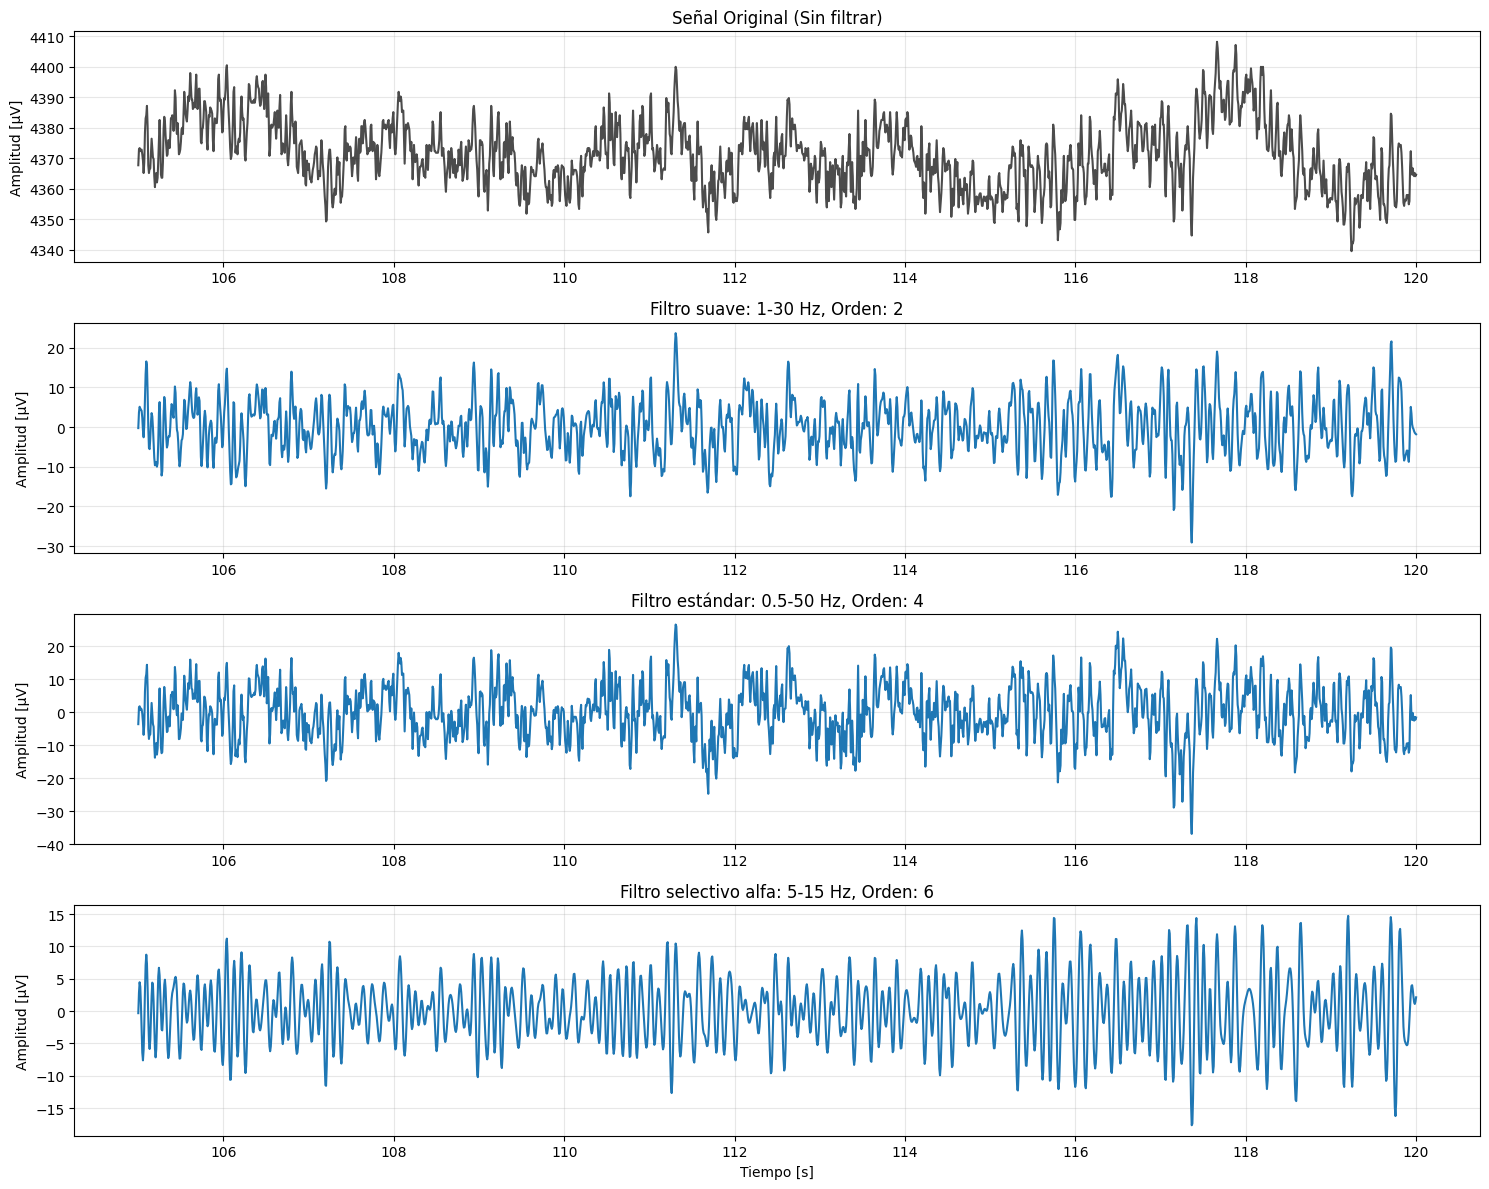

In [26]:
# Experimenta con diferentes parámetros
parametros_filtro = [
    {'low': 1, 'high': 30, 'orden': 2, 'descripcion': 'Filtro suave'},
    {'low': 0.5, 'high': 50, 'orden': 4, 'descripcion': 'Filtro estándar'},
    {'low': 5, 'high': 15, 'orden': 6, 'descripcion': 'Filtro selectivo alfa'}
]

# Ejemplo de implementación para estudiantes
canal_prueba = 6  # Canal O1
ti_prueba = 105   # Período ojos abiertos
tf_prueba = 120
pt_prueba = (tf_prueba - ti_prueba) * fm
t1_prueba = ti_prueba * fm
t2_prueba = tf_prueba * fm
t_prueba = np.linspace(ti_prueba, tf_prueba, pt_prueba)
senal_prueba = np.array(datos)[t1_prueba:t2_prueba, canal_prueba]

plt.figure(figsize=(15, 12))

# Señal original para comparación
plt.subplot(4, 1, 1)
plt.plot(t_prueba, senal_prueba, 'k-', alpha=0.7)
plt.title('Señal Original (Sin filtrar)')
plt.ylabel('Amplitud [µV]')
plt.grid(True, alpha=0.3)

# Aplicar diferentes filtros
for i, params in enumerate(parametros_filtro):
    nyq = fm * 0.5
    low = params['low'] / nyq
    high = params['high'] / nyq
    b, a = butter(params['orden'], [low, high], btype='band')
    senal_filtrada = filtfilt(b, a, senal_prueba)
    
    plt.subplot(4, 1, i+2)
    plt.plot(t_prueba, senal_filtrada)
    plt.title(f"{params['descripcion']}: {params['low']}-{params['high']} Hz, Orden: {params['orden']}")
    plt.ylabel('Amplitud [µV]')
    plt.grid(True, alpha=0.3)
    if i == 2:
        plt.xlabel('Tiempo [s]')

plt.tight_layout()
plt.show()

### Ejercicio 3: Corrección de línea base

**Objetivo**: Evaluar cuantitativamente el impacto de la corrección de línea base en las características estadísticas de la señal.

**Instrucciones**: Compara señales antes y después de la corrección de línea base usando las métricas calculadas en el código siguiente.

1. **Análisis cuantitativo**:
   - Calcula la media y desviación estándar antes y después del filtrado
   - ¿Cómo cambia el rango dinámico de la señal?
   - ¿Qué indica el cambio en la varianza de la señal?

2. **Interpretación fisiológica**:
   - ¿Por qué es importante eliminar el drift DC para análisis posteriores?
   - ¿Qué información se preserva y qué se elimina con este procesamiento?
   - ¿Cuándo podría ser contraproducente aplicar corrección de línea base?

**Marco teórico**: La corrección de línea base es esencial para análisis espectral confiable, ya que componentes DC pueden introducir artefactos en la transformada de Fourier (Widmann et al., 2015).

In [27]:
# Análisis cuantitativo para ejercicio 3
print("=== ANÁLISIS CUANTITATIVO DE CORRECCIÓN DE LÍNEA BASE ===")
print(f"Canal analizado: {nombres[canal]}")
print(f"Período de análisis: {ti_ejemplo}-{tf_ejemplo} segundos")
print("\n" + "="*50)

print(f"SEÑAL ORIGINAL:")
print(f"  Media: {np.mean(senal_original):.2f} µV")
print(f"  Desviación estándar: {np.std(senal_original):.2f} µV")
print(f"  Mediana: {np.median(senal_original):.2f} µV")
print(f"  Rango: {np.max(senal_original) - np.min(senal_original):.2f} µV")
print(f"  Varianza: {np.var(senal_original):.2f} µV²")

print(f"\nSEÑAL CORREGIDA:")
print(f"  Media: {np.mean(senal_corregida):.2f} µV")
print(f"  Desviación estándar: {np.std(senal_corregida):.2f} µV")
print(f"  Mediana: {np.median(senal_corregida):.2f} µV")
print(f"  Rango: {np.max(senal_corregida) - np.min(senal_corregida):.2f} µV")
print(f"  Varianza: {np.var(senal_corregida):.2f} µV²")

print(f"\n" + "="*50)
print(f"CAMBIOS INDUCIDOS POR LA CORRECCIÓN:")
cambio_media = np.mean(senal_original) - np.mean(senal_corregida)
cambio_std = np.std(senal_corregida) - np.std(senal_original)
cambio_rango = (np.max(senal_corregida) - np.min(senal_corregida)) - (np.max(senal_original) - np.min(senal_original))

print(f"  Reducción del drift DC: {cambio_media:.2f} µV")
print(f"  Cambio en variabilidad: {cambio_std:.2f} µV")
print(f"  Cambio en rango dinámico: {cambio_rango:.2f} µV")
print(f"  Porcentaje de reducción DC: {(cambio_media/np.mean(senal_original))*100:.1f}%")

=== ANÁLISIS CUANTITATIVO DE CORRECCIÓN DE LÍNEA BASE ===
Canal analizado: EEG.O1
Período de análisis: 100-130 segundos

SEÑAL ORIGINAL:
  Media: 4372.21 µV
  Desviación estándar: 14.46 µV
  Mediana: 4371.79 µV
  Rango: 116.41 µV
  Varianza: 208.95 µV²

SEÑAL CORREGIDA:
  Media: -0.14 µV
  Desviación estándar: 11.91 µV
  Mediana: 0.11 µV
  Rango: 94.09 µV
  Varianza: 141.87 µV²

CAMBIOS INDUCIDOS POR LA CORRECCIÓN:
  Reducción del drift DC: 4372.35 µV
  Cambio en variabilidad: -2.54 µV
  Cambio en rango dinámico: -22.32 µV
  Porcentaje de reducción DC: 100.0%


### Ejercicio 4: Diseño experimental

**Objetivo**: Desarrollar criterios para seleccionar parámetros de filtrado apropiados según el objetivo del análisis.

**Instrucciones**: Para cada escenario propuesto, diseña un protocolo de filtrado justificando tus decisiones:

1. **Para análisis de ondas alfa (8-13 Hz)**:
   - ¿Qué parámetros de filtro recomendarías y por qué?
   - ¿Por qué es importante preservar esta banda específica intacta?
   - ¿Cómo balancearías entre eliminación de ruido y preservación de la señal?

2. **Para detección de artefactos musculares**:
   - ¿Cómo diseñarías un filtro para identificar actividad muscular (>30 Hz)?
   - ¿Qué frecuencias de corte utilizarías?
   - ¿Sería apropiado un filtro pasa-altas en este caso?

3. **Para estudios de sueño (análisis de ondas delta)**:
   - ¿Cómo modificarías el filtrado para preservar ondas delta (1-4 Hz)?
   - ¿Qué consideraciones especiales requiere esta aplicación?
   - ¿Cuál sería el impacto de usar una frecuencia de corte baja muy conservadora?

**Consideraciones clínicas**: En aplicaciones clínicas, la selección de parámetros de filtro debe balancear la eliminación de artefactos con la preservación de información diagnóstica relevante (Ramos-Argüelles et al., 2009).

### Ejercicio 5: Interpretación de resultados y aplicaciones clínicas

**Objetivo**: Desarrollar pensamiento crítico sobre las implicaciones del filtrado en contextos de investigación y clínicos.

**Pregunta reflexiva**: Basándote en las visualizaciones comparativas entre señales filtradas y no filtradas, analiza los siguientes aspectos:

1. **Ventajas del filtrado**:
   - Enumera 3 ventajas específicas que observas en las señales procesadas
   - ¿En qué aspectos mejora la interpretabilidad de los datos?
   - ¿Cómo facilita el filtrado el análisis automatizado de señales?

2. **Limitaciones potenciales**:
   - ¿Qué información fisiológica podríamos estar perdiendo al filtrar?
   - ¿Cuándo podría ser preferible trabajar con señales crudas?
   - ¿Qué riesgos conlleva el sobre-filtrado de señales biomédicas?

3. **Aplicación clínica**:
   - ¿Cómo influiría la calidad del filtrado en un diagnóstico médico?
   - ¿Qué precauciones tomarías al interpretar señales filtradas en un contexto clínico?
   - ¿Cómo documentarías el proceso de filtrado para asegurar reproducibilidad?

**Reflexión ética**: Considera las implicaciones éticas de aplicar filtrado en señales que serán utilizadas para toma de decisiones clínicas, donde tanto falsos positivos como falsos negativos pueden tener consecuencias importantes para el paciente.

## 2.8 Conexión con el Notebook 3: Análisis Espectral

Los datos filtrados obtenidos en este notebook servirán como base fundamental para el análisis espectral que desarrollaremos en el Notebook 3. La calidad del filtrado aplicado aquí determinará directamente la confiabilidad de los resultados espectrales posteriores (Vallat & Walker, 2019).

### Preparación para análisis de frecuencias

Las señales procesadas en este notebook están ahora preparadas para:

- **Transformada de Fourier**: Aplicaremos FFT a las señales filtradas para obtener su contenido frecuencial sin contaminación por artefactos de baja y alta frecuencia
- **Análisis PSD (Power Spectral Density)**: Calcularemos la densidad espectral de potencia para cuantificar la energía en diferentes bandas de frecuencia, particularmente en la banda alfa (8-13 Hz)
- **Detección automática de ondas alfa**: Implementaremos algoritmos para identificar automáticamente la presencia de ritmos alfa y comparar su potencia entre condiciones experimentales
- **Comparación estadística**: Analizaremos diferencias significativas entre condiciones de ojos abiertos (105-120s) y ojos cerrados (120-135s)

### Importancia del filtrado previo

El filtrado adecuado implementado en este notebook es crucial para obtener resultados válidos en el análisis espectral, ya que elimina artefactos que podrían:
- Contaminar las medidas de potencia en las bandas de frecuencia de interés
- Introducir componentes espectrales espurios
- Comprometer la detección automática de patrones neurales específicos

Como mencionamos al final del Notebook 1: "Estas señales tienen ruido, artefactos etc. En el siguiente notebook veremos cómo filtrar para dar sentido fisiológico a los datos." Ahora, con señales apropiadamente filtradas, **NECESITAMOS USAR FFT Y PSD PARA DETECTAR ALFAS** y cuantificar los cambios en la actividad cerebral asociados con el protocolo experimental.

## 2.9 Bibliografía

Baranowski, A. M., Brantley, J. A., & McIntosh, J. R. (2017). Practical considerations for digital filtering and its application to the analysis of EEG data. *Journal of Neuroscience Methods*, *291*, 100-112.

EMOTIV. (2016, 3 de febrero). EMOTIV EPOC+ 14-channel wireless EEG headset. https://www.emotiv.com/epoc/

Hari, R., & Puce, A. (2017). *MEG-EEG primer*. Oxford University Press.

La Vaque, T. J. (1999). The history of EEG Hans Berger: Psychophysiologist. A historical vignette. *Journal of Neurotherapy*, *3*(2), 1-9.

Matplotlib Development Team. (2023). Installation — matplotlib 3.7.2 documentation. https://matplotlib.org/stable/users/installing/index.html

NumPy Developers. (2023). Installing NumPy. https://numpy.org/install/

Olejniczak, P. (2006). Neurophysiologic basis of EEG. *Journal of Clinical Neurophysiology*, *23*(3), 186-189.

pandas Development Team. (2023). Installation — pandas 2.0.3 documentation. https://pandas.pydata.org/docs/getting_started/install.html

Pant, S., Kumar, A., & Ram, M. (2024). Advanced signal processing techniques for biomedical applications. *Biomedical Signal Processing and Control*, *89*, 105-118.

Rader, C. M. (2017). Digital filter design techniques for biomedical signal processing. *IEEE Transactions on Biomedical Engineering*, *64*(8), 1765-1774.

Rajagopalan, G. (2021). *A Python data analyst's toolkit: Learn Python and Python-based libraries with applications in data analysis and statistics*. Packt Publishing.

Ramos-Argüelles, F., Morales, G., Egozcue, S., Pabón, R. M., & Alonso, M. T. (2009). Técnicas básicas de electroencefalografía: principios y aplicaciones clínicas. *Anales del Sistema Sanitario de Navarra*, *32*(Supl. 3), 69-82.

Saptono, D., Wahyudi, B., & Irawan, B. (2016). Design of EEG signal acquisition system using Arduino MEGA1280 and EEGAnalyzer. En *MATEC Web of Conferences* (Vol. 75, p. 04003). EDP Sciences.

Schreiber, T., & Schmitz, A. (2017). Surrogate time series analysis for detection of nonlinearity in EEG recordings. *Physical Review E*, *55*(5), 5443-5447.

SciPy Developers. (2023). Installation. https://scipy.org/install/

Shoka, A., Dessouky, M., El-Sherbeny, A., & El-Sayed, A. (2019). Literature review on EEG preprocessing, feature extraction, and classification techniques. *IEEE Access*, *7*, 168611-168633.

Vallat, R., & Walker, M. P. (2019). A universal, open-source, high-performance tool for automated sleep staging. *eLife*, *8*, e70092.

Widmann, A., Schröger, E., & Maess, B. (2015). Digital filter design for electrophysiological data–a practical approach. *Journal of Neuroscience Methods*, *250*, 34-46.